<a href="https://colab.research.google.com/github/Areej73/pbc-liver-cirrhosis-dataset/blob/main/Cirrhosis_Prediction_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cirrhosis_stage Prediction

## custom functions for exploratory purpose

In [49]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [50]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [52]:
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [53]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  no_unique = df[x].nunique()
  most_common_val = df[x].value_counts(dropna = False).index[0]
  # Calculate the frequency of the most common value
  freq = df[x].value_counts().values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(df) * 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  print(f"- Unique Values: {no_unique}")
  print(f"- Most common value: '{most_common_val}'  ocuurs {freq} times ({round(perc_most_common ,2)}%)")
  return fig, axes

In [118]:
# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

In [54]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# read file using pandas
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/cirrhosis.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Attribute Information
- 1) ID: unique identifier
- 2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
- 3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
- 4) Drug: type of drug D-penicillamine or placebo
- 5) Age: age in [days]
- 6) Sex: M (male) or F (female)
- 7) Ascites: presence of ascites N (No) or Y (Yes)
- 8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
- 9) Spiders: presence of spiders N (No) or Y (Yes)
- 10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
- 11) Bilirubin: serum bilirubin in [mg/dl]
- 12) Cholesterol: serum cholesterol in [mg/dl]
- 13) Albumin: albumin in [gm/dl]
- 14) Copper: urine copper in [ug/day]
- 15) Alk_Phos: alkaline phosphatase in [U/liter]
- 16) SGOT: SGOT in [U/ml]
- 17) Triglycerides: triglicerides in [mg/dl]
- 18) Platelets: platelets per cubic [ml/1000]
- 19) Prothrombin: prothrombin time in seconds [s]
- 20) Stage: histologic stage of disease (1, 2, 3, or 4)

In [56]:
# checking the unique identifier and use it as the index
int(df['ID'].nunique()/df.shape[0]*100)
# use id column as index
df.set_index('ID', inplace=True)
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Data Cleaning and feature Engineering

In [57]:
# checking for duplicates
df.duplicated().sum()

0

In [58]:
# check missing values in the dataframe as whole
df.isna().sum().sum()

1033

In [59]:
# checking missing values in each feature
missing = df.isna().sum()
missing[missing>0]

,0
Drug,106
Ascites,106
Hepatomegaly,106
Spiders,106
Cholesterol,134
Copper,108
Alk_Phos,106
SGOT,106
Tryglicerides,136
Platelets,11


In [60]:
#show the percentage of missing value in each column
missing_perc = (df.isna().sum()/df.shape[0]*100).apply(lambda x: round(x,2))
missing_perc[missing_perc>0]

,0
Drug,25.36
Ascites,25.36
Hepatomegaly,25.36
Spiders,25.36
Cholesterol,32.06
Copper,25.84
Alk_Phos,25.36
SGOT,25.36
Tryglicerides,32.54
Platelets,2.63


- the following features have missing values :
 - Drug :	106
 - Ascites :	106
 - Hepatomegaly : 106
 - Spiders	106
 - Cholesterol : 	134
 - Copper :	108
 - Alk_Phos : 106
 - SGOT :	106
 - Tryglicerides :	136
 - Platelets :	11
 - Prothrombin :	2
 -  Stage :	6
- 6 missing values in the target column (stage ) will be dropped ,
- columns with low percentages of missing values will be handled using median or mean for numeric columns and most frequent for categorical features
- high_missing values perantage features will be handled by imputing with the stage group median (groupby)

In [61]:
# drop missing values in the target column
df.dropna(subset=['Stage'], inplace=True)

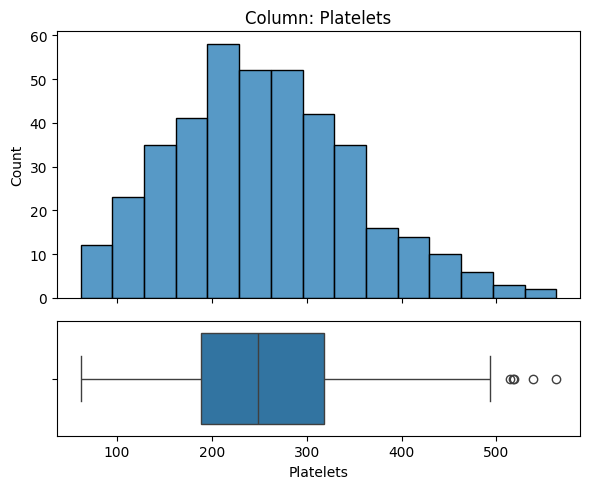

- NaN's Found: 11 (2.67%)
- Unique Values: 240
- Most common value: 'nan'  ocuurs 6 times (1.46%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Platelets'}, xlabel='Platelets', ylabel='Count'>,
        <Axes: xlabel='Platelets'>], dtype=object))

In [62]:
# handle the 2% missing values in Platelets
#show exploratory plotting for the feature
explore_numeric(df, 'Platelets' )


 the `distribution` of this column is `approximatly normal` , a `slight skweness` in the data due to `extreme values presence` , and `imputing with median` will be the approch

In [63]:
# impute missing values using median
df['Platelets'] = df['Platelets'].fillna(df['Platelets'].median())

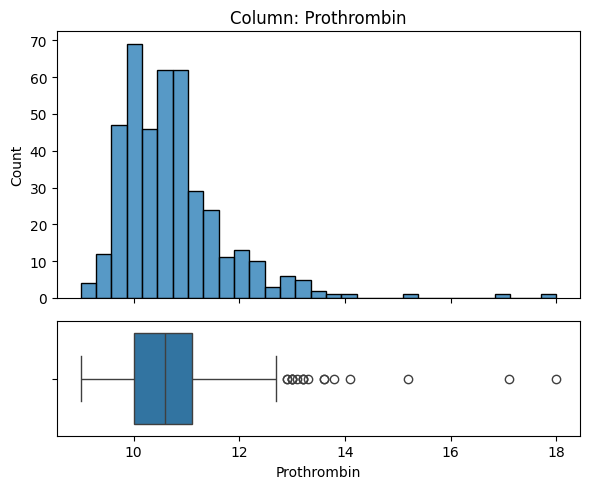

- NaN's Found: 2 (0.49%)
- Unique Values: 48
- Most common value: '10.6'  ocuurs 39 times (9.47%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Prothrombin'}, xlabel='Prothrombin', ylabel='Count'>,
        <Axes: xlabel='Prothrombin'>], dtype=object))

In [64]:
# handle missing values in Prothrombin
#show exploratory plotting for the feature
explore_numeric(df, 'Prothrombin' )


the data is skwed to the right , imputing the 2 missing values with median will not change the distribution  

In [65]:
# impute missing values using median
df['Prothrombin'] = df['Prothrombin'].fillna(df['Prothrombin'].median())

In [66]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Drug'].value_counts()

Stage  Drug           
1.0    D-penicillamine    12
       Placebo             4
2.0    D-penicillamine    35
       Placebo            32
3.0    Placebo            64
       D-penicillamine    56
4.0    D-penicillamine    55
       Placebo            54
Name: count, dtype: int64

In [67]:
# Fill missing values in 'Drug' based on the most frequent value within each 'Stage' group
df['Drug'] = df.groupby('Stage')['Drug'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))


In [68]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Tryglicerides'].median()

,Tryglicerides
Stage,
1.0,84.0
2.0,101.0
3.0,119.0
4.0,106.0


In [69]:
# handle missing values using median value of tryglicerides for each stage
df['Tryglicerides'] = df.groupby('Stage')['Tryglicerides'].transform(lambda x: x.fillna(x.median()))

In [70]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['SGOT'].median()

,SGOT
Stage,
1.0,64.325
2.0,108.500
3.0,112.375
4.0,122.450


In [71]:
# handle missing values using median value of SGOT for each stage
df['SGOT'] = df.groupby('Stage')['SGOT'].transform(lambda x: x.fillna(x.median()))

In [72]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Alk_Phos'].median()

,Alk_Phos
Stage,
1.0,706.0
2.0,1164.0
3.0,1257.5
4.0,1428.0


In [73]:
# handle missing values using median value of SGOT for each stage
df['Alk_Phos'] = df.groupby('Stage')['Alk_Phos'].transform(lambda x: x.fillna(x.median()))

In [74]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Copper'].median()

,Copper
Stage,
1.0,64.0
2.0,49.5
3.0,67.5
4.0,98.5


In [75]:
# handle missing values using median value of SGOT for each stage
df['Copper'] = df.groupby('Stage')['Copper'].transform(lambda x: x.fillna(x.median()))

In [76]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Cholesterol'].median()

,Cholesterol
Stage,
1.0,239.0
2.0,298.0
3.0,324.0
4.0,299.0


In [77]:
# handle missing values using median value of SGOT for each stage
df['Cholesterol'] = df.groupby('Stage')['Cholesterol'].transform(lambda x: x.fillna(x.median()))

In [78]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Spiders'].value_counts()

Stage  Spiders
1.0    N          15
       Y           1
2.0    N          58
       Y           9
3.0    N          90
       Y          30
4.0    N          59
       Y          50
Name: count, dtype: int64

In [79]:
# Fill missing values in 'Spiders' based on the most frequent value within each 'Stage' group
df['Spiders'] = df.groupby('Stage')['Spiders'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

In [80]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Hepatomegaly'].value_counts()

Stage  Hepatomegaly
1.0    N               16
2.0    N               48
       Y               19
3.0    N               67
       Y               53
4.0    Y               88
       N               21
Name: count, dtype: int64

In [81]:
# Fill missing values in 'Hepatomegaly' based on the most frequent value within each 'Stage' group
df['Hepatomegaly'] = df.groupby('Stage')['Hepatomegaly'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

In [82]:
# handling high percentage missing values _columns using median or most frequent value  for each class in stage column
df.groupby('Stage')['Ascites'].value_counts()

Stage  Ascites
1.0    N           16
2.0    N           65
       Y            2
3.0    N          119
       Y            1
4.0    N           88
       Y           21
Name: count, dtype: int64

In [83]:
# Fill missing values in 'Ascites' based on the most frequent value within each 'Stage' group
df['Ascites'] = df.groupby('Stage')['Ascites'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

In [84]:
#making sure there is no more missing values to handle
df.isna().sum().sum()

0

In [86]:
# check for inconsistencies
cat_columns = df.select_dtypes(include='object').columns
cat_columns

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [87]:
for col in cat_columns:
  print(f"{col}: {df[col].unique()}")

  print(df[col].value_counts())
  print("\n \n ")

Status: ['D' 'C' 'CL']
Status
C     230
D     157
CL     25
Name: count, dtype: int64

 
 
Drug: ['D-penicillamine' 'Placebo']
Drug
D-penicillamine    223
Placebo            189
Name: count, dtype: int64

 
 
Sex: ['F' 'M']
Sex
F    368
M     44
Name: count, dtype: int64

 
 
Ascites: ['Y' 'N']
Ascites
N    388
Y     24
Name: count, dtype: int64

 
 
Hepatomegaly: ['Y' 'N']
Hepatomegaly
N    217
Y    195
Name: count, dtype: int64

 
 
Spiders: ['Y' 'N']
Spiders
N    322
Y     90
Name: count, dtype: int64

 
 
Edema: ['Y' 'N' 'S']
Edema
N    348
S     44
Y     20
Name: count, dtype: int64

 
 


##Explore numeric features

In [88]:
#check statistics
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,1916.837379,18498.286408,3.227670,348.791262,3.500073,91.714806,1808.764806,120.122767,119.322816,255.912621,10.732767,3.024272
std,1099.941147,3823.705746,4.429421,195.255762,0.423948,75.586269,1888.878700,49.887867,54.703627,94.467529,1.024098,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1094.250000,15609.250000,0.800000,262.750000,3.247500,49.500000,982.000000,88.350000,91.000000,190.000000,10.000000,2.000000
50%,1713.500000,18628.000000,1.400000,299.000000,3.530000,67.500000,1257.500000,112.375000,106.000000,249.000000,10.600000,3.000000
75%,2610.500000,21200.500000,3.400000,350.750000,3.782500,102.000000,1716.500000,136.485000,128.500000,314.500000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


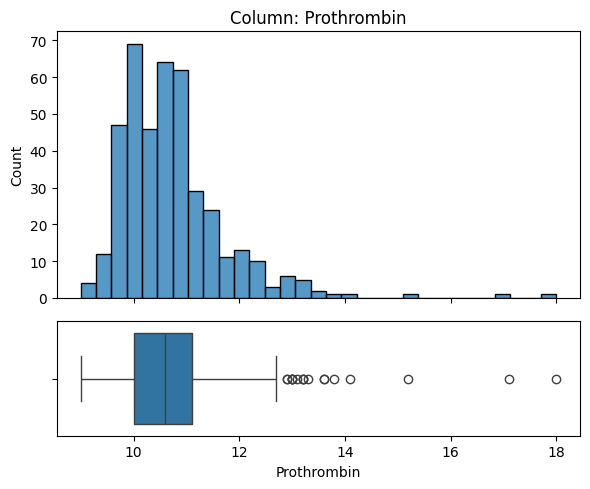

- NaN's Found: 0 (0.0%)
- Unique Values: 48
- Most common value: '10.6'  ocuurs 41 times (9.95%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Prothrombin'}, xlabel='Prothrombin', ylabel='Count'>,
        <Axes: xlabel='Prothrombin'>], dtype=object))

In [89]:
explore_numeric(df,'Prothrombin' )



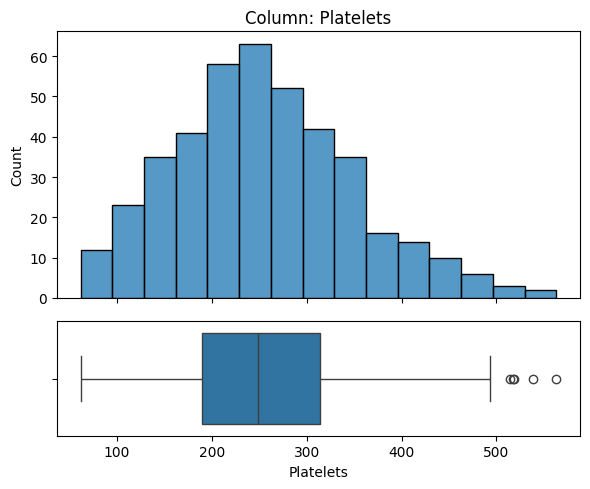

- NaN's Found: 0 (0.0%)
- Unique Values: 240
- Most common value: '249.0'  ocuurs 13 times (3.16%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Platelets'}, xlabel='Platelets', ylabel='Count'>,
        <Axes: xlabel='Platelets'>], dtype=object))

In [90]:
explore_numeric(df, 'Platelets' )


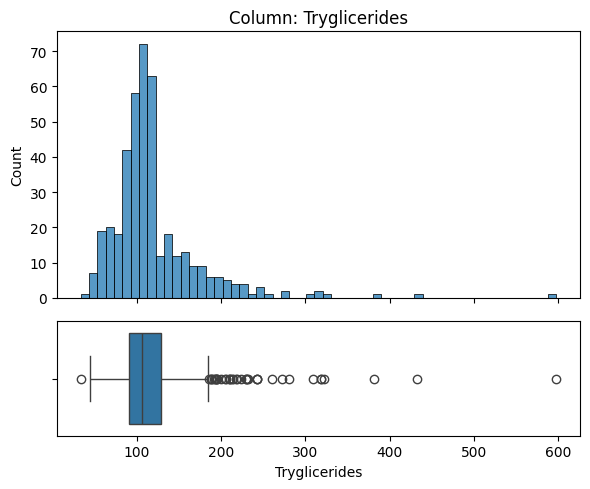

- NaN's Found: 0 (0.0%)
- Unique Values: 146
- Most common value: '106.0'  ocuurs 52 times (12.62%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Tryglicerides'}, xlabel='Tryglicerides', ylabel='Count'>,
        <Axes: xlabel='Tryglicerides'>], dtype=object))

In [91]:
explore_numeric(df, 'Tryglicerides' )


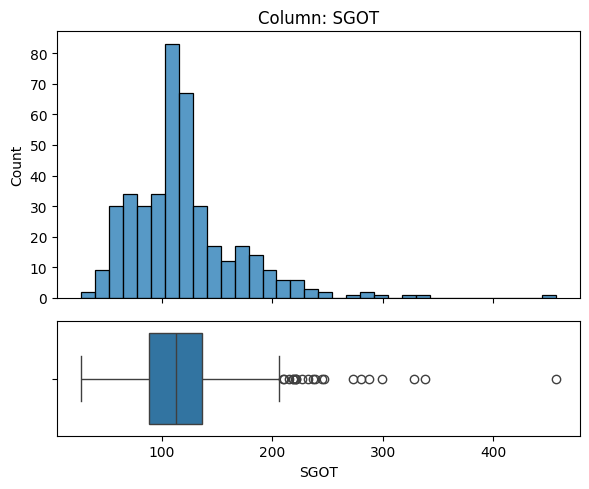

- NaN's Found: 0 (0.0%)
- Unique Values: 181
- Most common value: '122.45'  ocuurs 38 times (9.22%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: SGOT'}, xlabel='SGOT', ylabel='Count'>,
        <Axes: xlabel='SGOT'>], dtype=object))

In [92]:
explore_numeric(df, 'SGOT' )


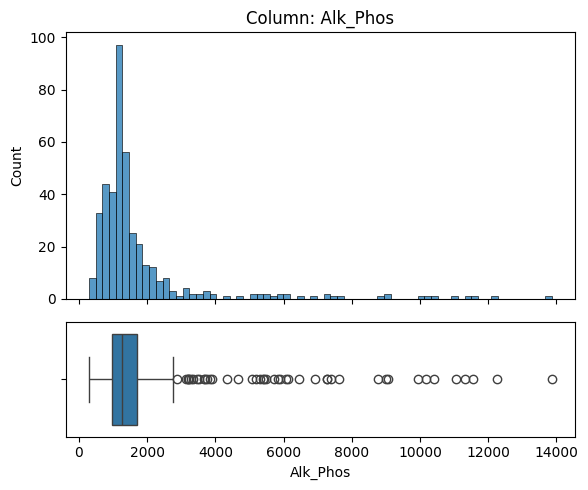

- NaN's Found: 0 (0.0%)
- Unique Values: 297
- Most common value: '1428.0'  ocuurs 37 times (8.98%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Alk_Phos'}, xlabel='Alk_Phos', ylabel='Count'>,
        <Axes: xlabel='Alk_Phos'>], dtype=object))

In [93]:
explore_numeric(df,'Alk_Phos')


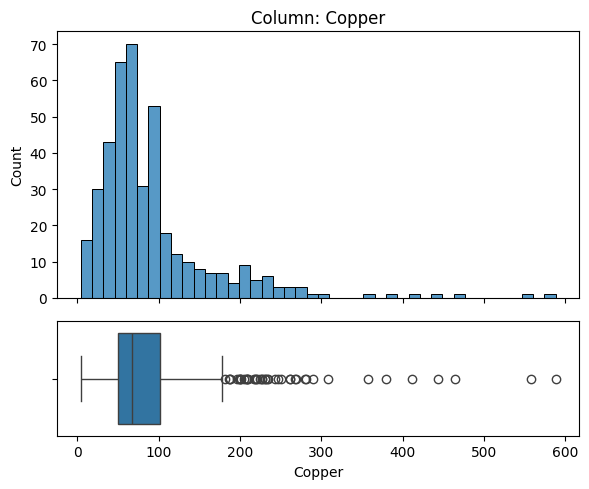

- NaN's Found: 0 (0.0%)
- Unique Values: 161
- Most common value: '98.5'  ocuurs 36 times (8.74%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Copper'}, xlabel='Copper', ylabel='Count'>,
        <Axes: xlabel='Copper'>], dtype=object))

In [94]:
explore_numeric(df, 'Copper' )


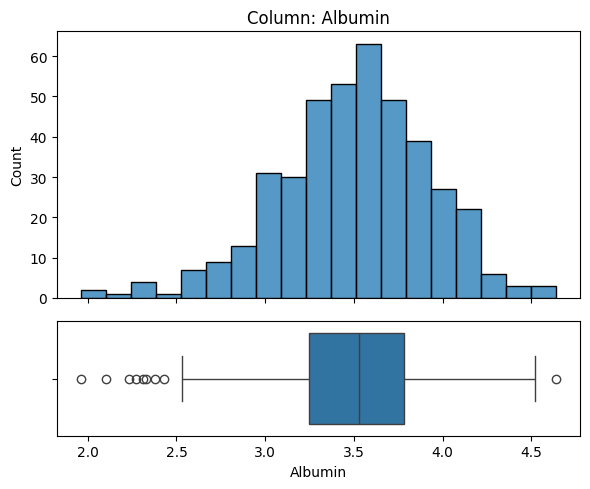

- NaN's Found: 0 (0.0%)
- Unique Values: 153
- Most common value: '3.35'  ocuurs 11 times (2.67%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Albumin'}, xlabel='Albumin', ylabel='Count'>,
        <Axes: xlabel='Albumin'>], dtype=object))

In [95]:
explore_numeric(df, 'Albumin' )


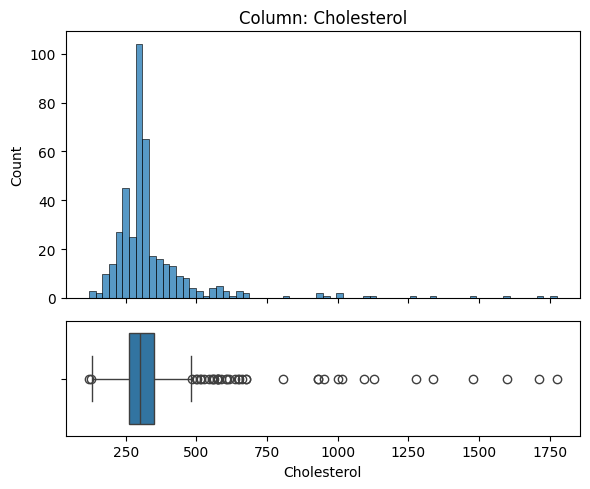

- NaN's Found: 0 (0.0%)
- Unique Values: 201
- Most common value: '299.0'  ocuurs 51 times (12.38%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Cholesterol'}, xlabel='Cholesterol', ylabel='Count'>,
        <Axes: xlabel='Cholesterol'>], dtype=object))

In [96]:
explore_numeric(df,'Cholesterol' )


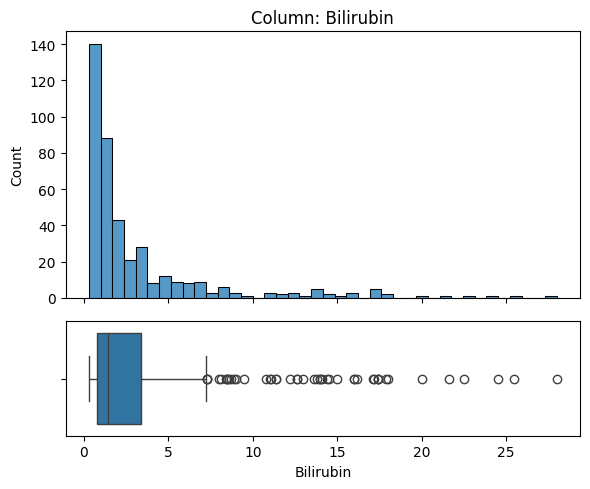

- NaN's Found: 0 (0.0%)
- Unique Values: 98
- Most common value: '0.7'  ocuurs 32 times (7.77%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Bilirubin'}, xlabel='Bilirubin', ylabel='Count'>,
        <Axes: xlabel='Bilirubin'>], dtype=object))

In [97]:
explore_numeric(df, 'Bilirubin' )


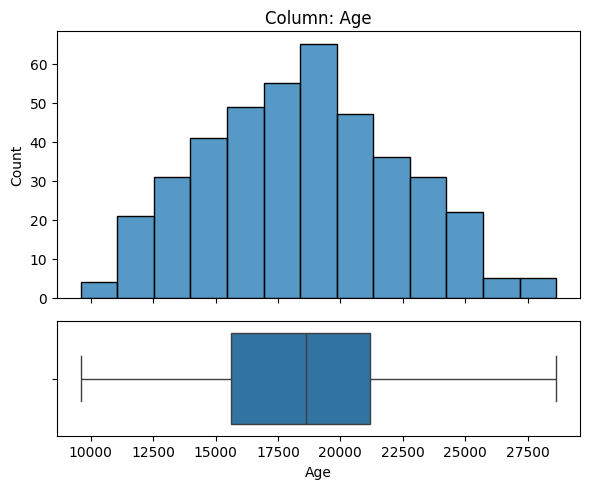

- NaN's Found: 0 (0.0%)
- Unique Values: 344
- Most common value: '19724'  ocuurs 7 times (1.7%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Age'}, xlabel='Age', ylabel='Count'>,
        <Axes: xlabel='Age'>], dtype=object))

In [98]:
explore_numeric(df, 'Age' )


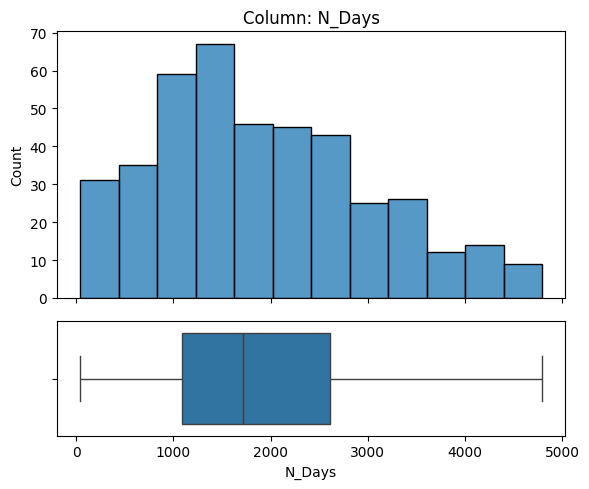

- NaN's Found: 0 (0.0%)
- Unique Values: 394
- Most common value: '2563'  ocuurs 2 times (0.49%)


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: N_Days'}, xlabel='N_Days', ylabel='Count'>,
        <Axes: xlabel='N_Days'>], dtype=object))

In [99]:
explore_numeric(df, 'N_Days' )

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'N_Days vs. Stage'}, xlabel='Stage', ylabel='N_Days'>)

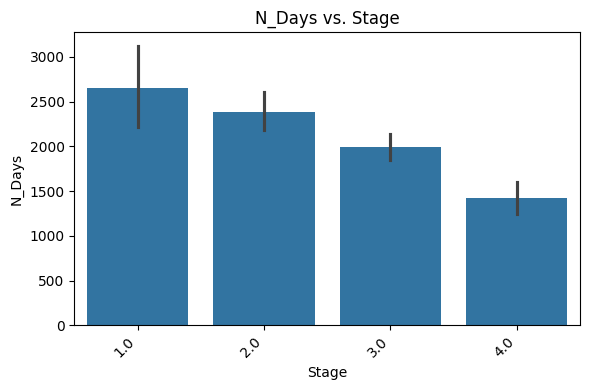

In [119]:
plot_numeric_vs_target(df, 'N_Days','Stage',target_type='class' )



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Age vs. Stage'}, xlabel='Stage', ylabel='Age'>)

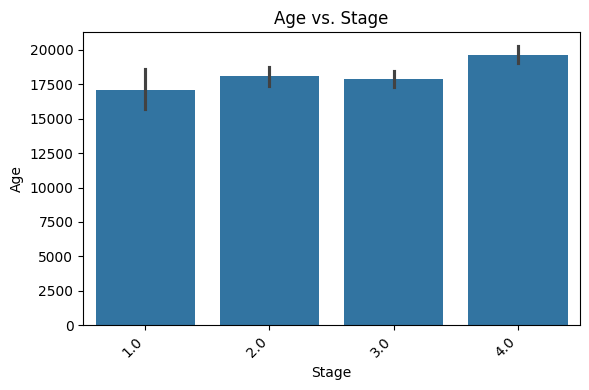

In [120]:
plot_numeric_vs_target(df, 'Age','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Bilirubin vs. Stage'}, xlabel='Stage', ylabel='Bilirubin'>)

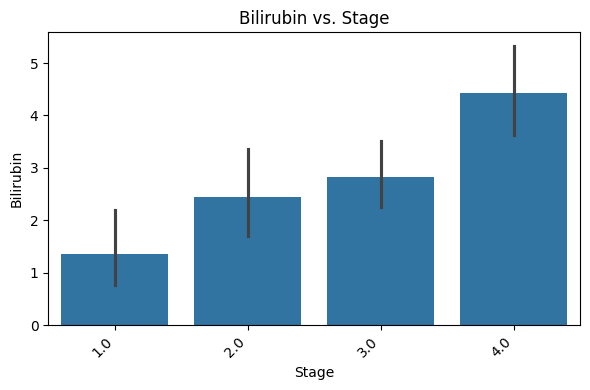

In [121]:
plot_numeric_vs_target(df, 'Bilirubin','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Cholesterol vs. Stage'}, xlabel='Stage', ylabel='Cholesterol'>)

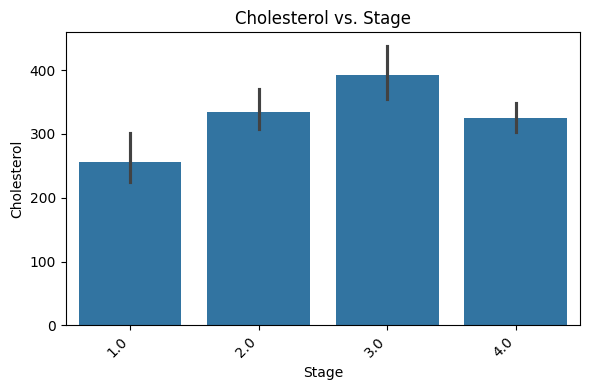

In [122]:
plot_numeric_vs_target(df, 'Cholesterol','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Albumin vs. Stage'}, xlabel='Stage', ylabel='Albumin'>)

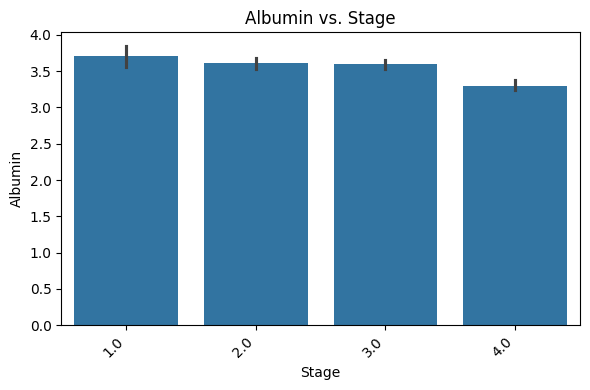

In [123]:
plot_numeric_vs_target(df, 'Albumin','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Copper vs. Stage'}, xlabel='Stage', ylabel='Copper'>)

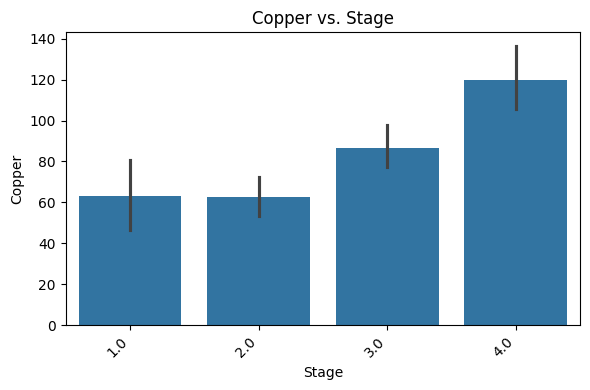

In [124]:
plot_numeric_vs_target(df, 'Copper','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Alk_Phos vs. Stage'}, xlabel='Stage', ylabel='Alk_Phos'>)

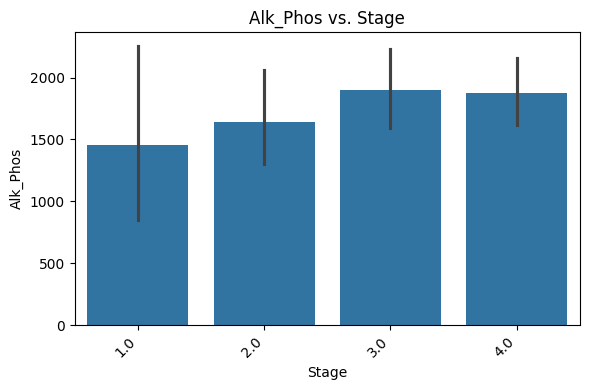

In [125]:
plot_numeric_vs_target(df, 'Alk_Phos','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'SGOT vs. Stage'}, xlabel='Stage', ylabel='SGOT'>)

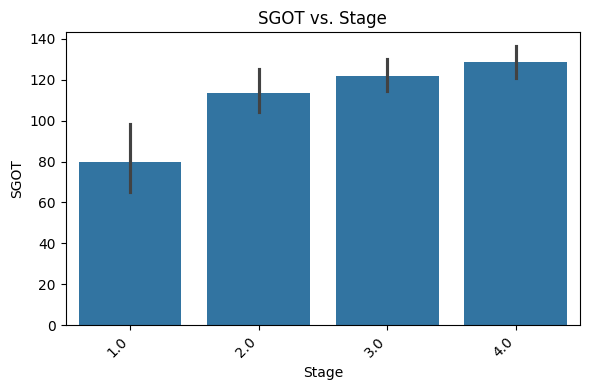

In [126]:
plot_numeric_vs_target(df, 'SGOT','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Tryglicerides vs. Stage'}, xlabel='Stage', ylabel='Tryglicerides'>)

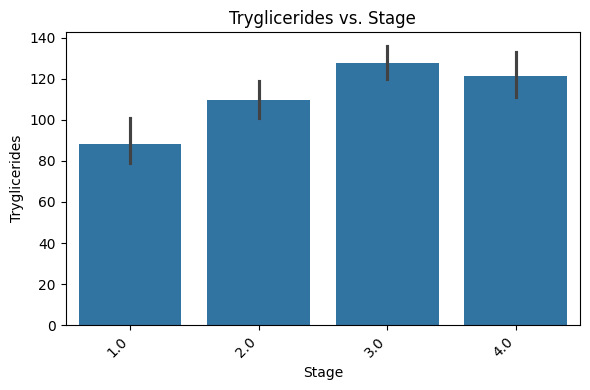

In [127]:
plot_numeric_vs_target(df, 'Tryglicerides','Stage',target_type='class' )


In [ ]:
plot_numeric_vs_target(df, 'Platelets','Stage',target_type='class' )


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Prothrombin vs. Stage'}, xlabel='Stage', ylabel='Prothrombin'>)

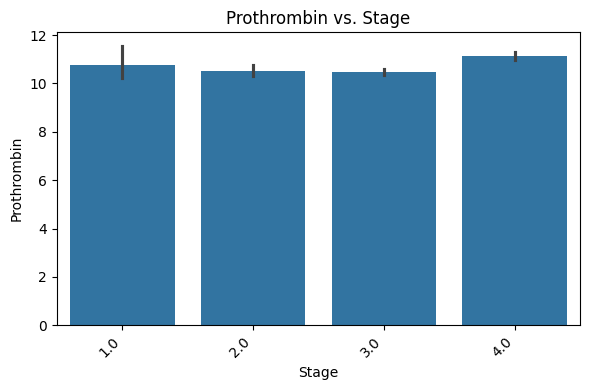

In [128]:
plot_numeric_vs_target(df, 'Prothrombin','Stage',target_type='class' )

##Explore categorical features

In [100]:
cat_columns

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


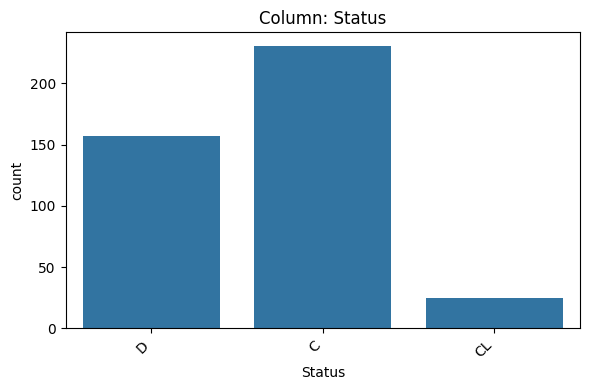

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'C' occurs 230 times (55.83%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Status'}, xlabel='Status', ylabel='count'>)

In [102]:
explore_categorical(df, 'Status')



<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


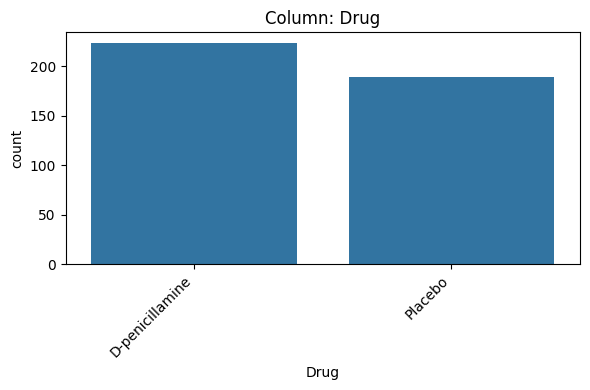

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'D-penicillamine' occurs 223 times (54.13%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Drug'}, xlabel='Drug', ylabel='count'>)

In [103]:
explore_categorical(df, 'Drug')


<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


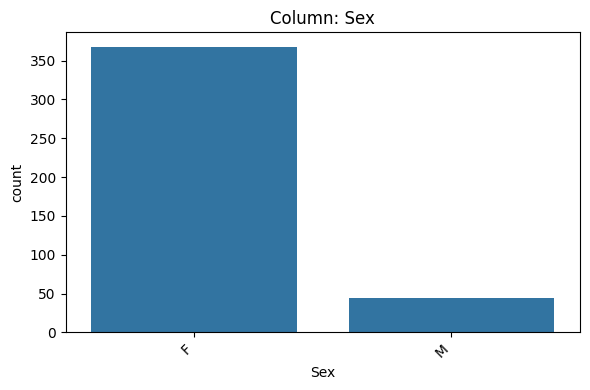

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'F' occurs 368 times (89.32%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Sex'}, xlabel='Sex', ylabel='count'>)

In [104]:
explore_categorical(df, 'Sex')


<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


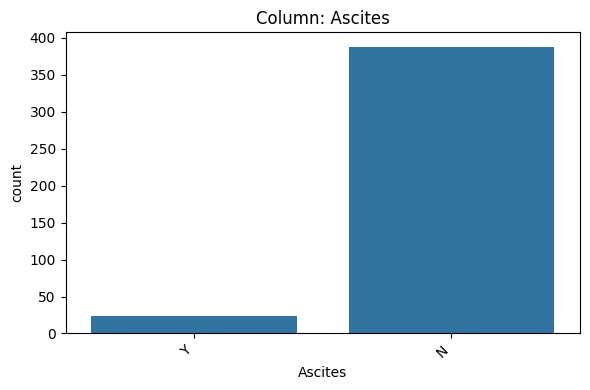

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'N' occurs 388 times (94.17%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Ascites'}, xlabel='Ascites', ylabel='count'>)

In [105]:
explore_categorical(df,'Ascites' )


<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


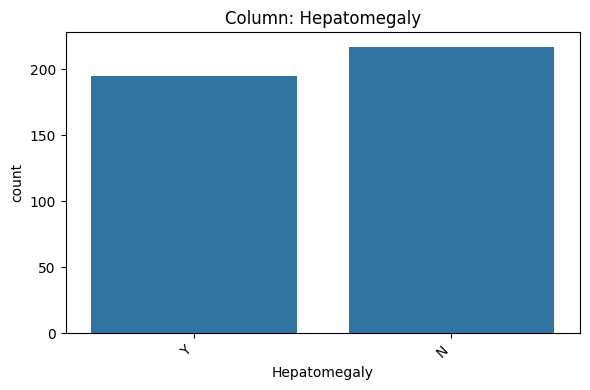

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'N' occurs 217 times (52.67%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Hepatomegaly'}, xlabel='Hepatomegaly', ylabel='count'>)

In [106]:
explore_categorical(df, 'Hepatomegaly')


<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


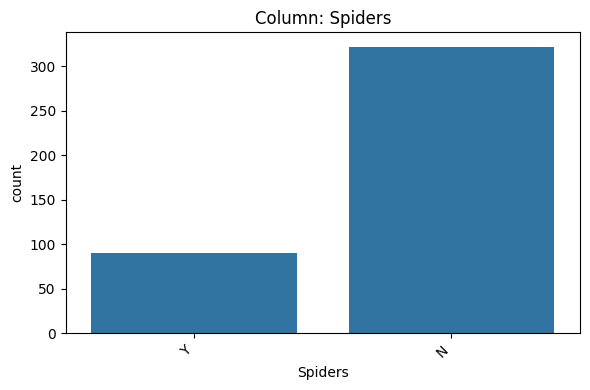

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'N' occurs 322 times (78.16%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Spiders'}, xlabel='Spiders', ylabel='count'>)

In [107]:
explore_categorical(df, 'Spiders')


<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


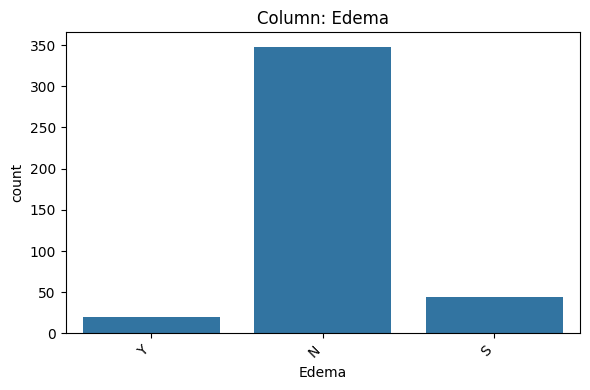

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'N' occurs 348 times (84.47%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Edema'}, xlabel='Edema', ylabel='count'>)

In [108]:
explore_categorical(df,'Edema')


<ipython-input-52-6572e99bf4bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


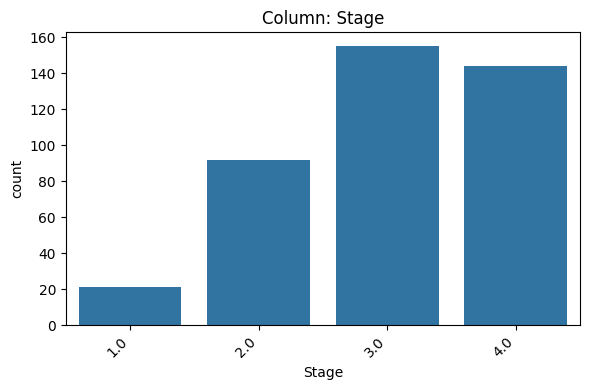

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '3.0' occurs 155 times (37.62%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Stage'}, xlabel='Stage', ylabel='count'>)

In [109]:
#explore target
explore_categorical(df, 'Stage')

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Status vs. Stage'}, xlabel='Status', ylabel='Percent'>)

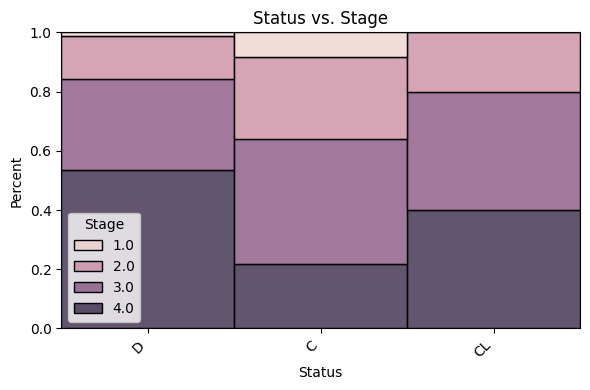

In [110]:
plot_categorical_vs_target(df, 'Status', 'Stage', target_type='class')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Drug vs. Stage'}, xlabel='Drug', ylabel='Percent'>)

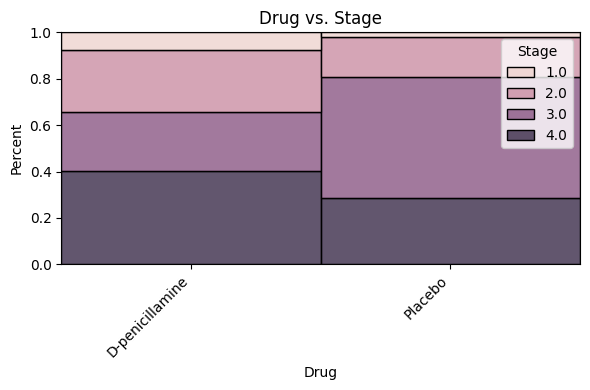

In [111]:
plot_categorical_vs_target(df, 'Drug', 'Stage', target_type='class')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Sex vs. Stage'}, xlabel='Sex', ylabel='Percent'>)

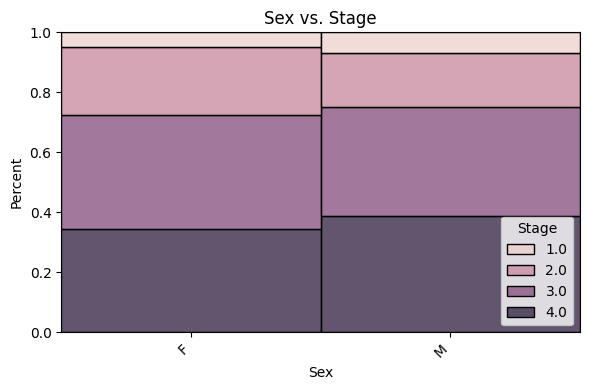

In [112]:
plot_categorical_vs_target(df, 'Sex', 'Stage', target_type='class')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Ascites vs. Stage'}, xlabel='Ascites', ylabel='Percent'>)

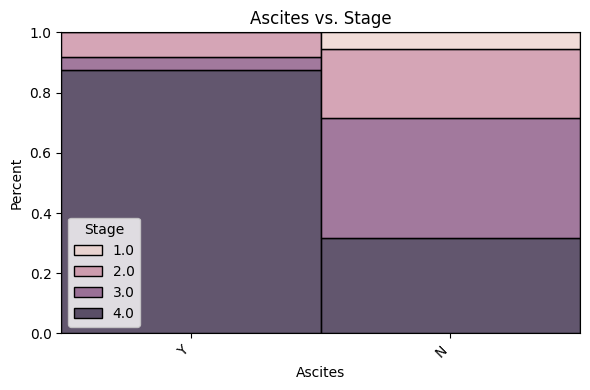

In [113]:
plot_categorical_vs_target(df,'Ascites', 'Stage', target_type='class')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Hepatomegaly vs. Stage'}, xlabel='Hepatomegaly', ylabel='Percent'>)

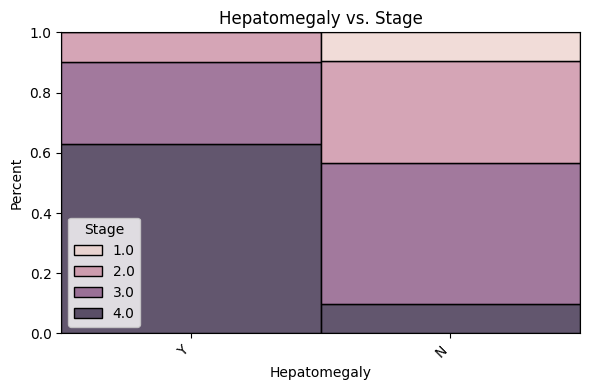

In [114]:
plot_categorical_vs_target(df, 'Hepatomegaly', 'Stage', target_type='class')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Spiders vs. Stage'}, xlabel='Spiders', ylabel='Percent'>)

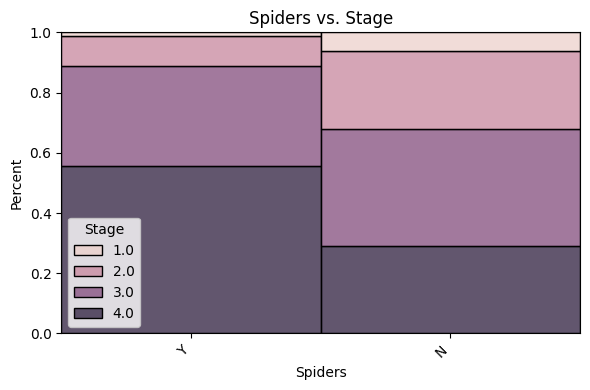

In [115]:
plot_categorical_vs_target(df, 'Spiders', 'Stage', target_type='class')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Edema vs. Stage'}, xlabel='Edema', ylabel='Percent'>)

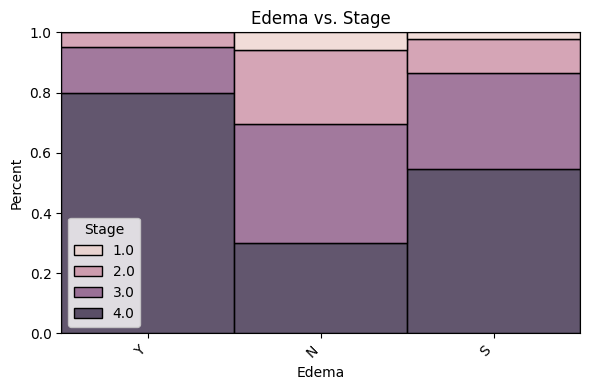

In [116]:
plot_categorical_vs_target(df, 'Edema', 'Stage', target_type='class')